## Convolutional Neural Network
**problem**: Chapter 6 of the textbook.

In this exercise, you will construct a convolutional neural network (CNN) for image recognition using the MNIST dataset. This dataset is a subset of a larger set available from NIST. The MNIST dataset contains a total of 70,000 images of handwritten digits from 0 to 9 with corresponding labels, of which 55,000 examples are in the training set, 5,000 in the validation set, and 10,000 in the test set. The digits have been size-normalized and centered in a fixedsize image, so you don’t need to do any preprocessing to the images.
## Imports ##

In [10]:
%matplotlib inline
import tensorflow as tf
import keras
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## Load data

Tensorflow and Keras allow us to import and download the MNIST dataset directly from their API.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

0


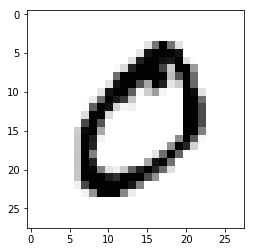

In [3]:
image_index = 1
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap='Greys')

## Neural Network ##

In [6]:
class NeuralNetwork(object):

    def __init__(self, learning_rate=0.5, debug=False):
        """
        Train NeuralNetwork by fixed learning rate
        """
        self.neuron_layers = []
        self.learning_rate = learning_rate
        self.debug = debug

    def train(self, dataset):
        for inputs, outputs in dataset:
            self.feed_forward(inputs)
            self.feed_backword(outputs)
            self.update_weights(self.learning_rate)

    def feed_forward(self, inputs):
        s = inputs
        for (i, l) in enumerate(self.neuron_layers):
            s = l.feed_forward(s)
            if self.debug:
                print ("Layer %s:" % (i+1), " output:%s" % s)
        return s

    def feed_backword(self, outputs):
        layer_num = len(self.neuron_layers)
        l = layer_num
        previous_deltas = [] 
        while l != 0:
            current_layer = self.neuron_layers[l - 1]
            if len(previous_deltas) == 0:
                for i in range(len(current_layer.neurons)):
                    error = -(outputs[i] - current_layer.neurons[i].output)
                    current_layer.neurons[i].calculate_delta(error)
            else:
                previous_layer = self.neuron_layers[l]
                for i in range(len(current_layer.neurons)):
                    error = 0
                    for j in range(len(previous_deltas)):
                        error += previous_deltas[j] * previous_layer.neurons[j].weights[i]
                    current_layer.neurons[i].calculate_delta(error)
            previous_deltas = current_layer.get_deltas()
            if self.debug:
                print ("Layer %s:" % l, "deltas:%s" % previous_deltas)
            l -= 1

    def update_weights(self, learning_rate):
        for l in self.neuron_layers:
            l.update_weights(learning_rate)

    def calculate_total_error(self, dataset):
        """
        Return mean squared error of dataset
        """
        total_error = 0
        for inputs, outputs in dataset:
            actual_outputs = self.feed_forward(inputs)
            for i in range(len(outputs)):
                total_error += (outputs[i] - actual_outputs[i]) ** 2
        return total_error

    def get_output(self, inputs):
        return self.feed_forward(inputs)

    def add_layer(self, neruon_layer):
        self.neuron_layers.append(neruon_layer)

    def dump(self):
        for (i, l) in enumerate(self.neuron_layers):
            print ("Dump layer: %s" % (i+1))
            l.dump()

In [7]:
class NeuronLayer(object):

    def __init__(self, input_num, neuron_num, init_weights=[], bias=1):
        self.neurons = []
        weight_index = 0
        for i in range(neuron_num):
            n = Neuron(input_num)
            for j in range(input_num):
                if weight_index < len(init_weights):
                    n.weights[j] = init_weights[weight_index]
                    weight_index += 1
            n.bias = bias
            self.neurons.append(n)

    def feed_forward(self, inputs):
        outputs = []
        for n in self.neurons:
            outputs.append(n.calculate_output(inputs))
        return outputs

    def get_deltas(self):
        return [n.delta for n in self.neurons]

    def update_weights(self, learning_rate):
        for n in self.neurons:
            n.update_weights(learning_rate)

    def dump(self):
        for (i, n) in enumerate(self.neurons):
            print ("\t-Dump neuron: %s" % (i+1))
            n.dump()

## Neuron ##
### Initialize the Weights of Neural Network ###
Using random function to randomly generate the weights.
### Calculate Output ###
$$z=\omega_{1}*x_{1}+\omega_{2}∗x_{2}+\omega_{3}∗bias$$

then using activation function(sigmoid function) to calculate the output

$$s=\frac{1}{1+e^{−z}}$$
### Activation Function ###
$$s=\frac{1}{1+e^{−z}}$$
### Calculate Delta ###
The error influence:
$$\delta_{L}=(realOutput−expectOutput)∗g′(z)$$

$$g'(z)=o∗(1−o)$$
### Update Weights ###
$$\delta_{L}=\omega_{L+1}\delta_{L+1}∗g′(z)$$

new weights: $$\omega_{i}=\omega_{i}−\alpha∗\delta∗x_{i}$$

new bias: $$\omega_{bias}=\omega_{bias}−\alpha∗\delta$$


In [8]:
class Neuron(object):

    def __init__(self, weight_num):
        self.weights = []
        self.bias = 0
        self.output = 0
        self.delta = 0
        self.inputs = []
        for i in range(weight_num):
            self.weights.append(random.random())

    def calculate_output(self, inputs):
        self.inputs = inputs
        if len(inputs) != len(self.weights):
            raise Exception("Input number not fit weight number")
        self.output = 0
        for (i, w) in enumerate(self.weights):
            self.output += w * inputs[i]
        self.output = self.activation_function(self.output + self.bias)
        return self.output

    def activation_function(self, x):
        """Using sigmoid function"""
        return 1 / (1 + math.exp(-x))

    def calculate_delta(self, error):
        """ Using g' of sigmoid """
        self.delta = error * self.output * (1 - self.output)

    def update_weights(self, learning_rate):
        for (i, w) in enumerate(self.weights):
            new_w = w - learning_rate * self.delta * self.inputs[i]
            self.weights[i] = new_w
        self.bias = self.bias - learning_rate * self.delta

    def dump(self):
        print ("\t\t-- weights:", self.weights)
        print ("\t\t-- bias:", self.bias)

## Train ##

In [12]:
nn = NeuralNetwork()
hidden_layer_1 = NeuronLayer(input_num=15, neuron_num=10, bias=1)
hidden_layer_2 = NeuronLayer(input_num=10, neuron_num=10, bias=1)
output_layer = NeuronLayer(input_num=10, neuron_num=1, bias=1)
nn.add_layer(hidden_layer_1)
nn.add_layer(hidden_layer_2)
nn.add_layer(output_layer)
# nn.dump()

In [ ]:
tracking = []
for i in range(1000):
    nn.train(dataset)
    tracking.append(nn.calculate_total_error(dataset))